# Xtream AI assignement, Challenge 1: Data Exploration and Cleaning 

## Purpose

_'Discover the why behind every price tag.'_

In this notebook, I perform initial data exploration on the diamond.csv dataset I was given and I'll simultaneously process and clean the data while uncovering new insights. 

The processed data is saved in a .csv and then given in input to the Training.ipynb notebook.


## Dataset Description

In this section, I have summarized some additional research findings and addressed questions that have emerged from the data I have received.
| Feature       | Description                                      |
|-------------|--------------------------------------------------|
| carat       | Weight of the diamond (1 carat = 200mg)          |
| cut         | Cut quality (to maximize light performance ~ sparkle) |
| color       | [_GIA_](https://www.gia.edu/gia-about/4cs-color) Color grade                                   |
| clarity     | Clarity grade                                    |
| depth       | The z-depth of the diamond (as a percentage of z)|
| table       | The table-width of the diamond's top (as a percentage of x) |
| price       | Diamonds price (probably in USD as in [_stonealgo_](https://www.stonealgo.com/diamond-prices/))                                  |
| x           | Width  (in mm / if round, is the diameter)       |
| y           | Length  (in mm)                                  |
| z           | Depth   (in mm)                                  |

### Color scale values meaning:
From D(Colorless - HIGH GRADE) to Z(Light Yellow - LOWER GRADE).

'Yellow diamonds are usually more expensive than white diamonds because they're harder to find and more difficult to mine.
[_lndgold_](https://www.londongold.com/education/yellow-diamonds-vs-white-diamonds/#:~:text=If%20you're%20trying%20to,than%20other%20fancy%20colored%20diamonds).

'The highest valued diamonds are colorless. As the color intensity increases (especially yellow or brown), the diamond's grade decreases. However, diamonds with intense colouration, such as yellow or brown, that surpass the Z grade, experience a significant price increase. These diamonds are classified as "fancy" and include pink, green, and blue diamonds.'
[_gemosoc_](https://www.gemsociety.org/article/diamond-color/)

### Clarity scale values meaning:
If visible imperfections are present, their value can decrease or make them less appealing:

- FL - Flawless
- VVS1 - Very, very slightly included, first degree
- VVS2 - Very, very slightly included, second degree
- VS1 - Very slightly included, first degree
- VS2 - Very slightly included, second degree
- SI1 - Slightly included, first degree
- SI2 - Slightly included, second degree.
- I1 - Included Diamonds, first degree.

Typical diamonds dimension range : [4 mm, 11 mm].

Since depth is derived from the z and z-depth dimensions, and table is derived from table-width and x, they might not provide additional unique information beyond what is already captured by the original dimensions (Keep an eye on this).

## Previous works

### Extracted informations from [_GEMO_](https://www.researchgate.net/publication/375647223_Gemo_An_AI-Powered_Approach_to_Color_Clarity_Cut_Prediction_and_Valuation_for_Gemstones):
Gemstone value and beauty are linked to the precision and quality of their cuts. 
Factors such as color, cut, carat weight, and clarity play significant roles in determining the valuation of gemstones.

- Regression with Random Forest to predict the price
- train-test % split:  80-20
- Metric: RMSE, used to determine the degree of variation between expected and observed prices
- Shape and weight are factors to keep under observation.

### Extracted informations from [_AEMLA_](https://ieeexplore.ieee.org/document/10080618):

- Metrics: R2score, Low RMSE, MAE values, CV Score
- Linear Regression, Random Forest, Decision Tree Random Forest, Cat-Boost Regressor and XGB Regressor.  
- Faceted diamonds are evaluated based on their color, cut, clarity, and carat weight to assess their overall quality
- The two most important aspects of a product are its weight and its color

## Library import


In [1]:
#!pip install pandas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Dataset Exploration

In [2]:
diamonds_df=pd.read_csv('../datasets/diamonds/diamonds.csv')
print(diamonds_df)
print(diamonds_df.describe())

      carat        cut color clarity  depth  table  price     x     y     z
0      1.10      Ideal     H     SI2   62.0   55.0   4733  6.61  6.65  4.11
1      1.29      Ideal     H     SI1   62.6   56.0   6424  6.96  6.93  4.35
2      1.20    Premium     I     SI1   61.1   58.0   5510  6.88  6.80  4.18
3      1.50      Ideal     F     SI1   60.9   56.0   8770  7.43  7.36  4.50
4      0.90  Very Good     F     VS2   61.7   57.0   4493  6.17  6.21  3.82
...     ...        ...   ...     ...    ...    ...    ...   ...   ...   ...
4995   0.38      Ideal     H    VVS2   62.3   53.3    832  4.65  4.69  2.91
4996   0.33    Premium     G    VVS2   61.3   59.0    927  4.45  4.42  2.72
4997   1.25      Ideal     J    VVS2   62.1   56.0   5980  6.81  6.84  4.24
4998   0.31    Premium     F     VS2   62.9   58.0    802  4.31  4.27  2.70
4999   0.30      Ideal     H    VVS1   61.2   57.0    655  4.30  4.39  2.66

[5000 rows x 10 columns]
             carat        depth        table        price     

In [3]:
diamonds_df.dtypes

carat      float64
cut         object
color       object
clarity     object
depth      float64
table      float64
price        int64
x          float64
y          float64
z          float64
dtype: object

In [4]:
diamonds_df.nunique()

carat       202
cut           5
color         7
clarity       8
depth       121
table        78
price      3179
x           474
y           471
z           304
dtype: int64

What is visible here is that some 'x''y''z' dimensions are = '0' and some 'prices' reach '-1' values.

I might need to remove 0 values for the dimensions and the negative values for the prices since those are nonsensical.

What could be the reasons for negative and null values?
1) If the diamond is round, the y dimension might be null.
2) negative price? Cannot think of a logical reason, maybe a template value for a price that never came.

In [5]:
# Divide numerical features from categorical ones
numerical_features = diamonds_df.select_dtypes(include=['number']).columns.tolist()
categorical_features = diamonds_df.select_dtypes(include=['object', 'category']).columns.tolist()
print(f'Numerical_features: ',numerical_features,'\nCategorical features: ',categorical_features)

Numerical_features:  ['carat', 'depth', 'table', 'price', 'x', 'y', 'z'] 
Categorical features:  ['cut', 'color', 'clarity']


## Numerical features overview

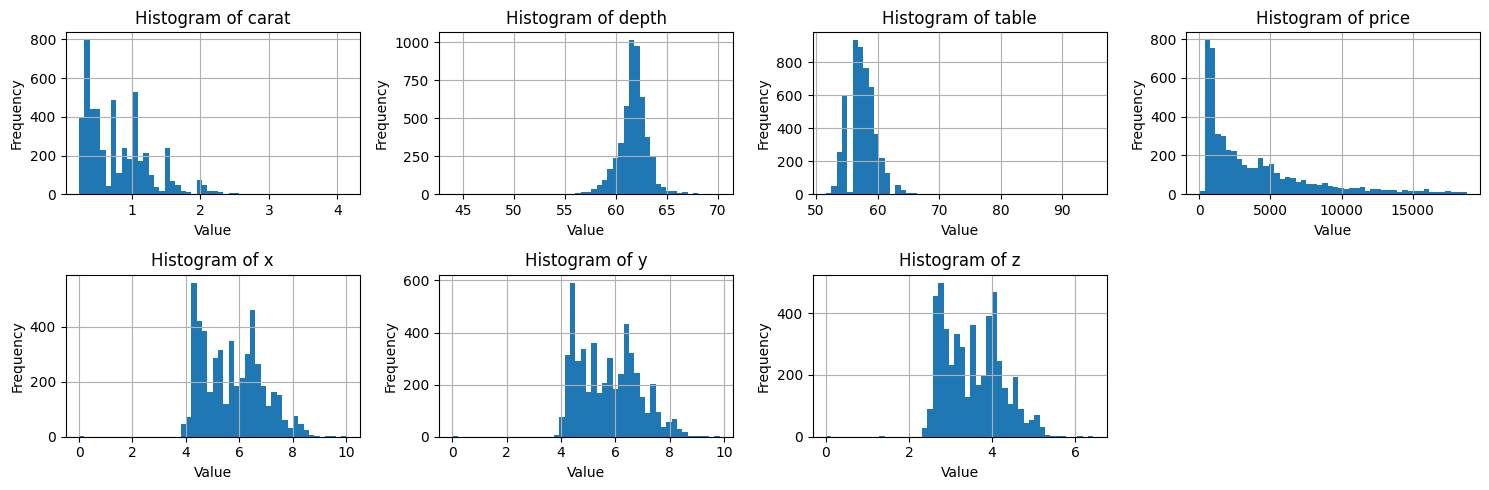

In [6]:
# Histograms for numerical features
plt.figure(figsize=(15, 5))
for i, feature in enumerate(numerical_features):
    plt.subplot(2, 4, i +1)
    diamonds_df[feature].plot(kind='hist', title=f'Histogram of {feature}', bins=50)
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.grid(True)

plt.tight_layout()
plt.show()

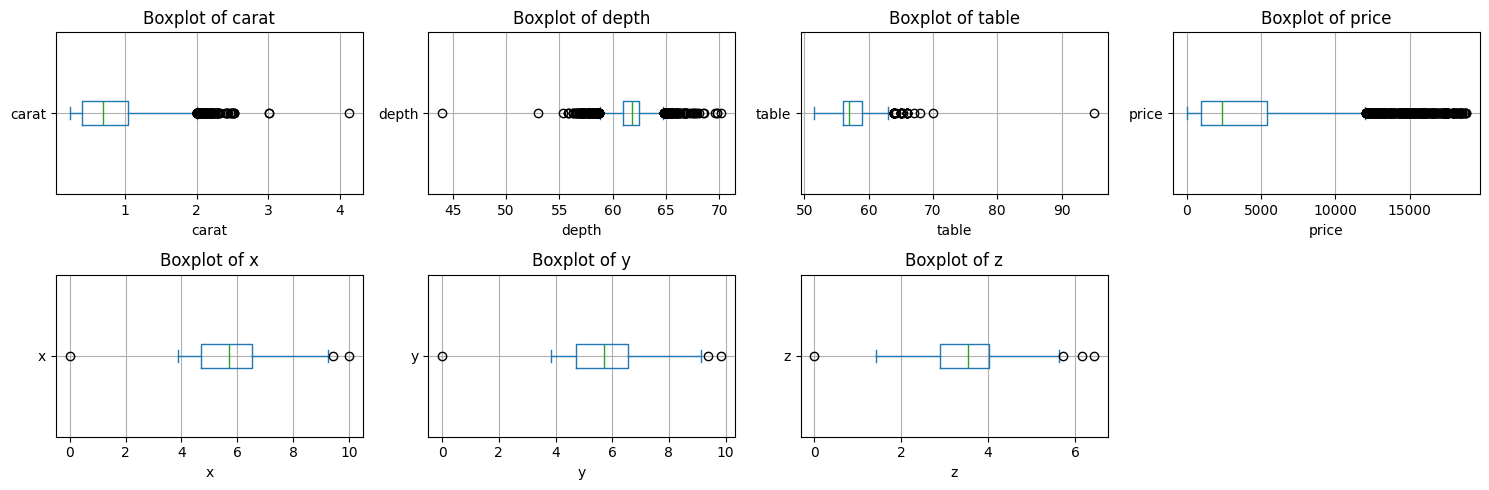

In [7]:
#boxplot for numerical features
plt.figure(figsize=(15, 5))
for i, feature in enumerate(numerical_features):
    plt.subplot(2, 4, i +1)
    diamonds_df[feature].plot(kind='box', title=f'Boxplot of {feature}', vert=False)
    plt.xlabel(feature)
    plt.grid(True)
plt.tight_layout()
plt.show()

#add outliers count from the boxplots

We can see that dimensional features follow a normal distribution.
Carat, price, depth and table are skewed and present more outliers

It appears that there are very few rows with x, y, or z features equal to 0.

In [8]:
# Count rows where 'x' and 'y' are equal to 0
count_zero_x = len(diamonds_df[(diamonds_df['x'] == 0) ])
count_zero_y = len(diamonds_df[(diamonds_df['y'] == 0) ])
count_zero_z = len(diamonds_df[(diamonds_df['z'] == 0) ])

print(count_zero_x, count_zero_y,count_zero_z)

# Select rows with values equal to 0
null_df= diamonds_df[(diamonds_df == 0).any(axis=1)]
null_df


1 1 1


,carat,cut,color,clarity,depth,table,price,x,y,z
4321,2.25,Premium,H,SI2,62.8,59.0,18034,0.0,0.0,0.0


The intuition about the diamonds being round is not verified: as there is only one entry with 'x', 'y', and 'z' values equal to 0.

It is possible to remove it since it will not significantly affect the overall dataset distribution.

## Dataset Cleaning
### NULL values

In [9]:
#Check null values
diamonds_df.isnull().sum()

carat      0
cut        0
color      0
clarity    0
depth      0
table      0
price      0
x          0
y          0
z          0
dtype: int64

### 0 values

In [10]:
#Delete rows with values =0
clean_diamonds_df = diamonds_df[~(diamonds_df == 0).any(axis=1)]
len(clean_diamonds_df)

4999

### Duplicates
Remove the duplicate entries if exist.

In [11]:
duplicates = clean_diamonds_df[clean_diamonds_df.duplicated()]

clean_diamonds_df = clean_diamonds_df.drop_duplicates()
print(duplicates,'\n', clean_diamonds_df)

      carat      cut color clarity  depth  table  price     x     y     z
4943   0.31  Premium     E     VS2   61.6   59.0    872  4.35  4.32  2.67 
       carat        cut color clarity  depth  table  price     x     y     z
0      1.10      Ideal     H     SI2   62.0   55.0   4733  6.61  6.65  4.11
1      1.29      Ideal     H     SI1   62.6   56.0   6424  6.96  6.93  4.35
2      1.20    Premium     I     SI1   61.1   58.0   5510  6.88  6.80  4.18
3      1.50      Ideal     F     SI1   60.9   56.0   8770  7.43  7.36  4.50
4      0.90  Very Good     F     VS2   61.7   57.0   4493  6.17  6.21  3.82
...     ...        ...   ...     ...    ...    ...    ...   ...   ...   ...
4995   0.38      Ideal     H    VVS2   62.3   53.3    832  4.65  4.69  2.91
4996   0.33    Premium     G    VVS2   61.3   59.0    927  4.45  4.42  2.72
4997   1.25      Ideal     J    VVS2   62.1   56.0   5980  6.81  6.84  4.24
4998   0.31    Premium     F     VS2   62.9   58.0    802  4.31  4.27  2.70
4999   0.30   

### Negative prices

In [12]:
# Check negative price rows
neg_price = clean_diamonds_df[clean_diamonds_df['price'] <= 0]
neg_price

,carat,cut,color,clarity,depth,table,price,x,y,z
331,1.00,Good,F,SI1,64.1,60.0,-1,6.25,6.19,3.99
2121,0.34,Ideal,E,VS2,59.8,56.0,-1,4.55,4.54,2.72
2484,1.75,Ideal,J,SI1,63.3,59.0,-1,7.63,7.57,4.81
2933,1.51,Ideal,H,VS2,62.5,55.0,-1,7.29,7.34,4.57
3155,0.31,Ideal,G,VS2,61.7,57.0,-1,4.33,4.36,2.68
3317,1.02,Premium,D,VS2,59.8,61.0,-1,6.61,6.54,3.93
3445,0.30,Premium,H,SI1,59.3,59.0,-1,4.38,4.36,2.59
3904,0.90,Very Good,G,SI2,64.2,56.0,-1,6.04,6.11,3.90
3980,0.41,Very Good,H,VS2,63.4,58.0,-1,4.77,4.66,2.99
4188,0.79,Ideal,H,VVS1,62.0,56.0,-1,5.92,5.96,3.68


In [13]:
clean_diamonds_df = clean_diamonds_df.drop(neg_price.index)
len(clean_diamonds_df)

4988

## Categorical Features overview

 Categorial features countplots are shown below.

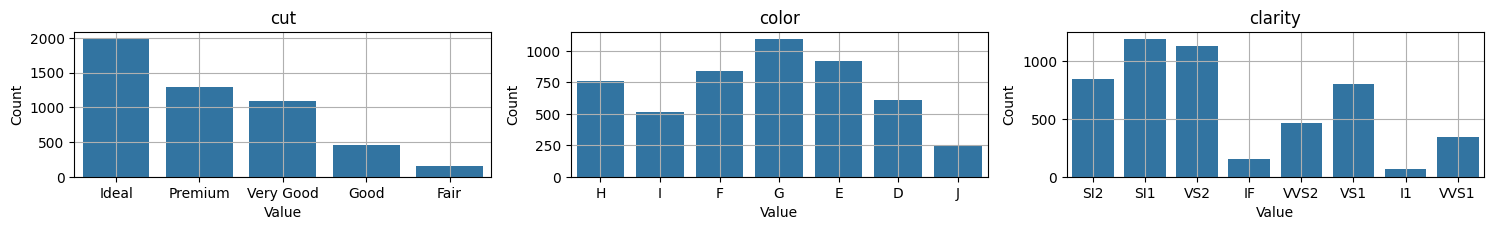

In [14]:
plt.figure(figsize=(20, 4))
for i, feature in enumerate(categorical_features):
    plt.subplot(2, 4, i + 1)
    sns.countplot(data=clean_diamonds_df, x=feature)
    plt.title(f'{feature}')
    plt.xlabel('Value')
    plt.ylabel('Count')
    plt.grid(True)

plt.tight_layout()
plt.show()

Since the categorical features value ordering is based on the stone's quality, I apply the label encoding technique to transform the categorical values into ordered numerical ones.

I assign lower quality to lower values.

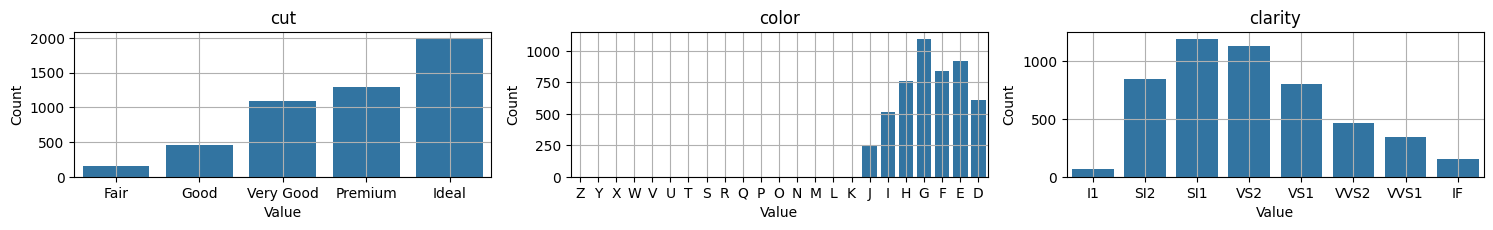

In [15]:
# Countplot for categorical features
cut_order = ['Fair', 'Good', 'Very Good', 'Premium', 'Ideal']
color_order = reversed([chr(i) for i in range(ord('D'), ord('Z')+1)])
clarity_order = ['I1', 'SI2', 'SI1', 'VS2', 'VS1', 'VVS2', 'VVS1','IF']

clean_diamonds_df['cut'] = pd.Categorical(clean_diamonds_df['cut'], categories=cut_order, ordered=True)
clean_diamonds_df['color'] = pd.Categorical(clean_diamonds_df['color'], categories=color_order, ordered=True)
clean_diamonds_df['clarity'] = pd.Categorical(clean_diamonds_df['clarity'], categories=clarity_order, ordered=True)

plt.figure(figsize=(20, 4))
for i, feature in enumerate(categorical_features):
    plt.subplot(2, 4, i + 1)
    sns.countplot(data=clean_diamonds_df, x=feature)
    plt.title(f'{feature}')
    plt.xlabel('Value')
    plt.ylabel('Count')
    plt.grid(True)

plt.tight_layout()
plt.show()


In [16]:
#Compute percentage of 'Ideal' class in 'cut' feature
filtered_data = clean_diamonds_df[clean_diamonds_df['cut'] == 'Ideal']
len(filtered_data)/len(clean_diamonds_df)

0.3983560545308741

For the 'cut' feature the Ideal class occupies 40% of the data

For the 'color' feature the most frequent class is G (Near Colorless), which confirms that yellowish stones are less requested/easy to extract.

For the 'clarity' feature the most frequent classes are VS2 - Very slightly included, second degree and SI1 - Slightly included, first degree.


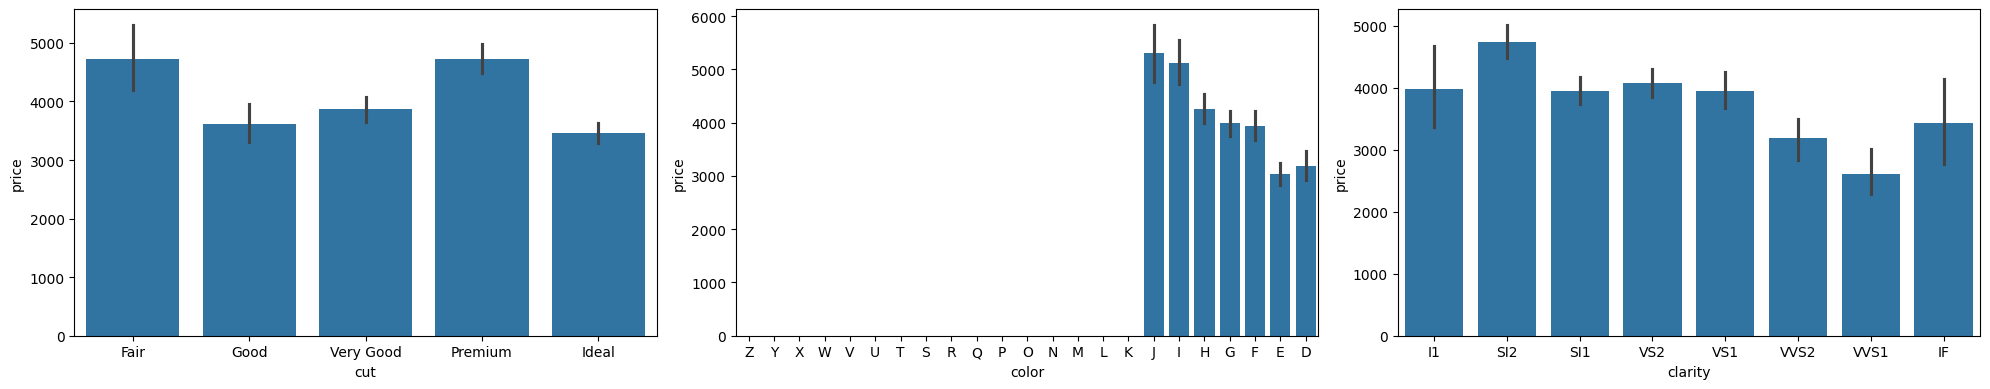

In [17]:
# Barplots for categorical feature against price
plt.figure(figsize=(20, 4))
for i,feature in enumerate(categorical_features):
    plt.subplot(1, 3, i+1)
    sns.barplot(x=feature, y='price', data=clean_diamonds_df)
plt.tight_layout()
plt.show()

All the categorical features classes are quite evenly distributed against the price apart from the color feature, which only presents a part of the possible values.
The models will not learn information about absent classes.

Apply the encoding of the categorical features to the dataframe

In [18]:
clean_diamonds_df['cut_enc'] = clean_diamonds_df['cut'].cat.codes
clean_diamonds_df['color_enc'] = clean_diamonds_df['color'].cat.codes
clean_diamonds_df['clarity_enc'] = clean_diamonds_df['clarity'].cat.codes
clean_diamonds_df=clean_diamonds_df.drop(['cut', 'color', 'clarity'],axis=1)
clean_diamonds_df


,carat,depth,table,price,x,y,z,cut_enc,color_enc,clarity_enc
0,1.10,62.0,55.0,4733,6.61,6.65,4.11,4,18,1
1,1.29,62.6,56.0,6424,6.96,6.93,4.35,4,18,2
2,1.20,61.1,58.0,5510,6.88,6.80,4.18,3,17,2
3,1.50,60.9,56.0,8770,7.43,7.36,4.50,4,20,2
4,0.90,61.7,57.0,4493,6.17,6.21,3.82,2,20,3
...,...,...,...,...,...,...,...,...,...,...
4995,0.38,62.3,53.3,832,4.65,4.69,2.91,4,18,5
4996,0.33,61.3,59.0,927,4.45,4.42,2.72,3,19,5
4997,1.25,62.1,56.0,5980,6.81,6.84,4.24,4,16,5
4998,0.31,62.9,58.0,802,4.31,4.27,2.70,3,20,3


## Scatterplots and correlation

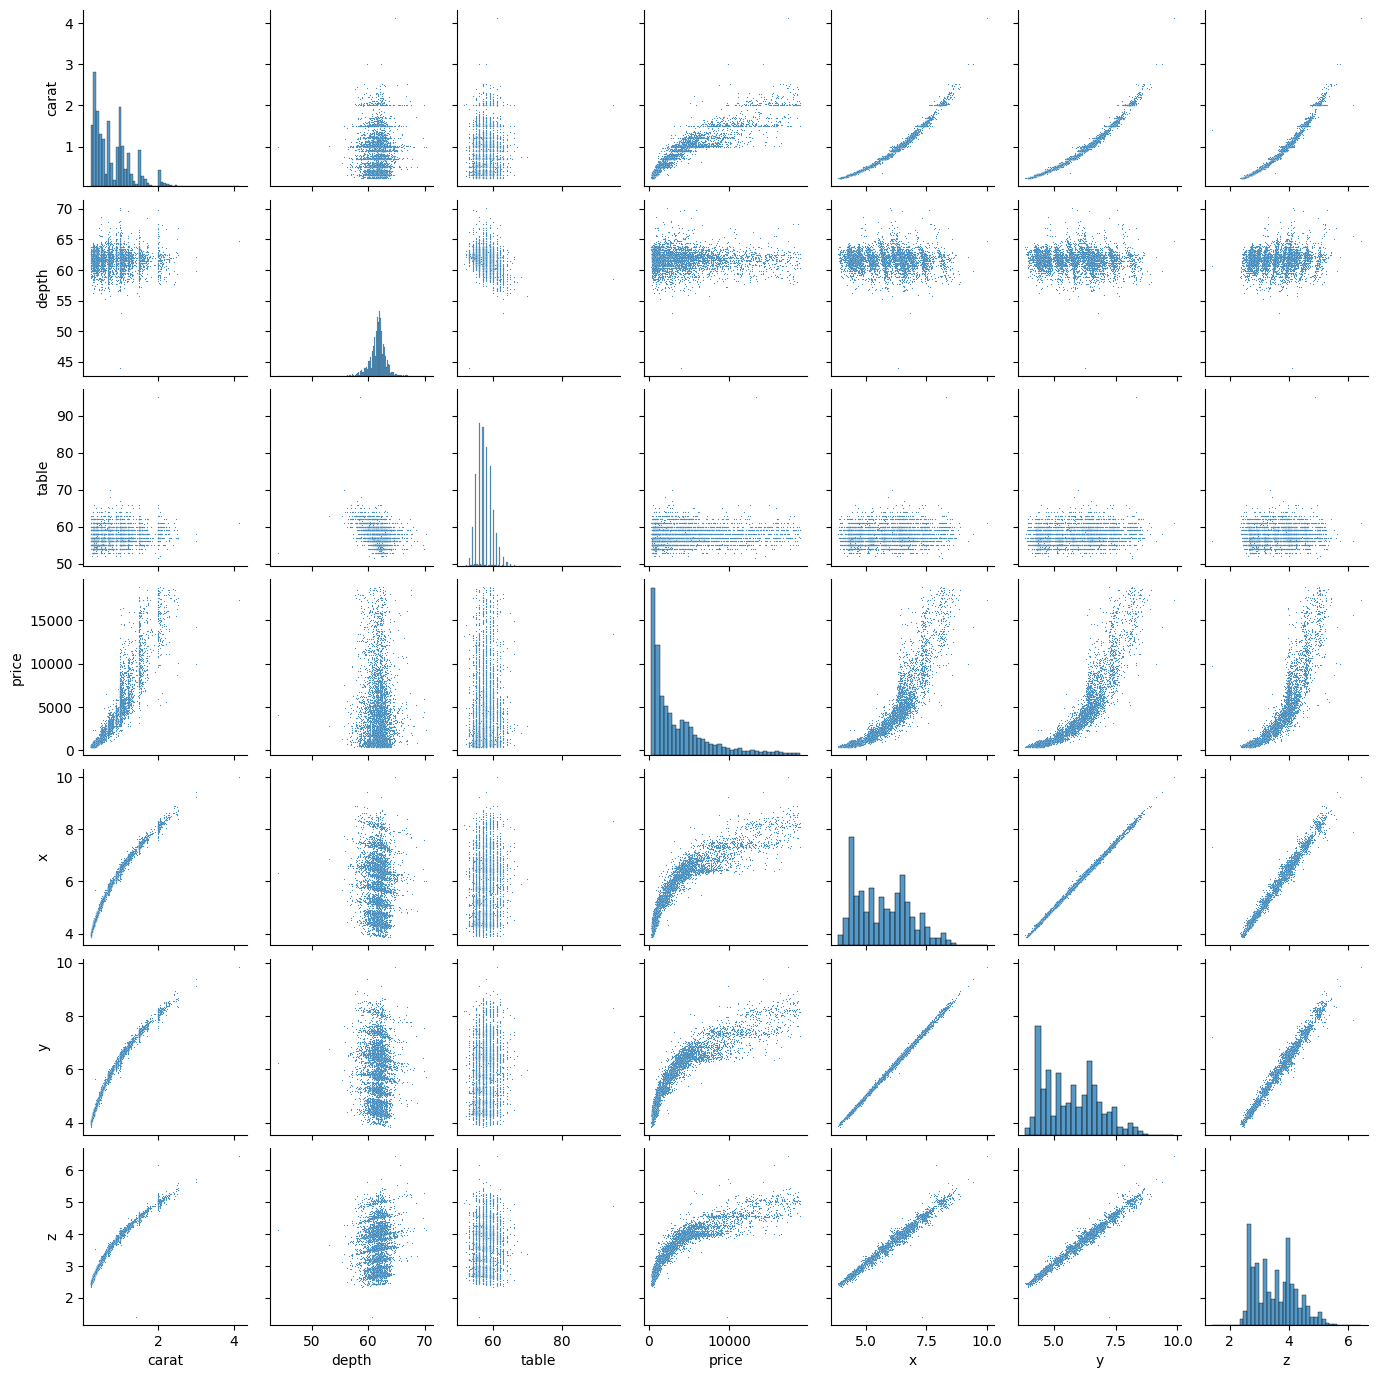

In [19]:
numerical_df =clean_diamonds_df[numerical_features]
marker_size = 0.7
sns.pairplot(numerical_df, plot_kws={'s': marker_size} , height=2)
plt.show()

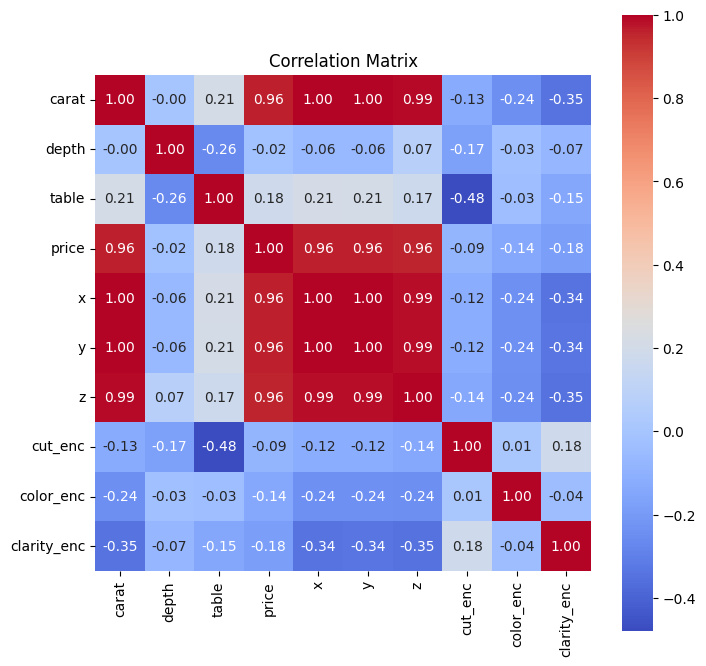

In [20]:
#Correlation matrix
correlation_matrix = clean_diamonds_df.corr(method='spearman')

plt.figure(figsize=(8, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", square=True)
plt.title("Correlation Matrix")
plt.show()

In the plot above, the correlation between features is shown.
I use Spearman's matrix because is less sensitive to outliers and skewed distributions.

Correlation values above 0.8 are considered as an index of strong positive correlation between two variables.

I observe that:
- Carat is strongly positively correlated to x,y,z, dimensions. It makes sense since the carat represents the weight of the diamond, a bigger dimension implies a higher weight (with the same density).
- Dimensions are strongly correlated with each other.
- Price is strongly correlated to carat.
- Is curious that table and depth are not strongly correlated to x and z.

In conclusion 2 of the 3 x,y and z, can be removed from the dataset  

In [21]:
# Remove x,y,z,
reduced_diamonds_df = clean_diamonds_df.drop(['x'], axis=1)

## Price vs Carat

At some point, the strong correlation between carat and price is lost, after 2.5 the carat dimension is dispersed and outliers are visible.

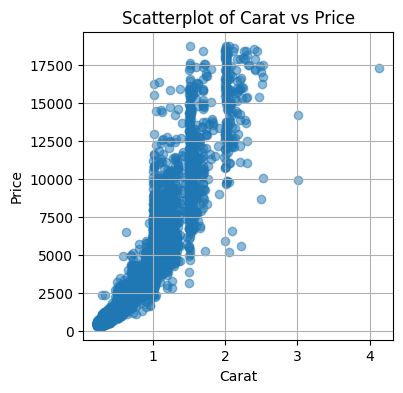

In [22]:
plt.figure(figsize=(4,4))
plt.scatter(reduced_diamonds_df['carat'], reduced_diamonds_df['price'], alpha=0.5)
plt.title('Scatterplot of Carat vs Price')
plt.xlabel('Carat')
plt.ylabel('Price')
plt.grid(True)
plt.show()

### Outliers removal
Remove the outliers from the dataset using the Interquartile Range (IQR) method

In [23]:
len(reduced_diamonds_df)

4988

In [24]:
 # Calculate Q1, Q3, and IQR for each feature  FALLO SOLO PER NUMERICAL
selected_features = ['carat','depth','table','price']
Q1 = reduced_diamonds_df[selected_features].quantile(0.25)
Q3 = reduced_diamonds_df[selected_features].quantile(0.75)
IQR = Q3 - Q1

# Calculate lower and upper limits for each feature
lower_limit = Q1 - 1.5 * IQR
upper_limit = Q3 + 1.5 * IQR

# Remove outliers
df_no_outliers = reduced_diamonds_df[~((reduced_diamonds_df[selected_features] < lower_limit).any(axis=1) | (reduced_diamonds_df[selected_features] > upper_limit).any(axis=1))]

print(len(df_no_outliers))

4412


ValueError: num must be an integer with 1 <= num <= 8, not 9

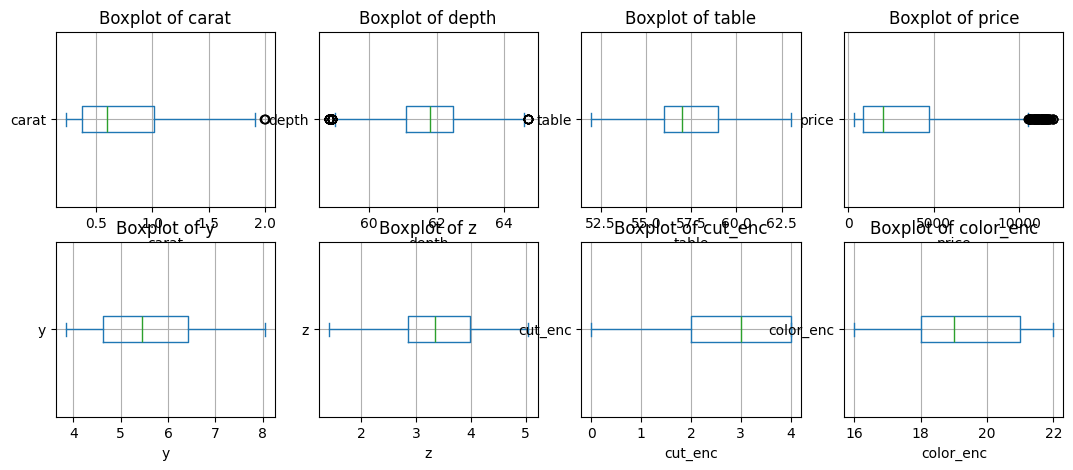

In [25]:
#boxplot for numerical features again
plt.figure(figsize=(13, 5))
for i, feature in enumerate(df_no_outliers):
    plt.subplot(2, 4, i +1)
    df_no_outliers[feature].plot(kind='box', title=f'Boxplot of {feature}', vert=False)
    plt.xlabel(feature)
    plt.grid(True)
plt.tight_layout()
plt.show()

#add outliers count from the boxplots

In [ ]:
# histograms for numerical features

plt.figure(figsize=(13, 6))
for i, feature in enumerate(df_no_outliers):
    plt.subplot(2, 4, i +1)
    df_no_outliers[feature].plot(kind='hist', title=f'Histogram of {feature}', bins=50)
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.grid(True)

plt.tight_layout()
plt.show()

## Data trasformation
Since both the price and carat distributions are left-skewed, I transform them into a normal distribution by applying the logarithm function.

In [ ]:
# Applying a log transformation to the target variable (price) to improve normality
df_no_outliers.loc[:, 'log_price'] = np.log(df_no_outliers['price'])
df_no_outliers.loc[:, 'log_carat'] = np.log(df_no_outliers['carat'])

Plot the before and after the log transformation

In [ ]:
# histograms for numerical features

plt.figure(figsize=(20, 3))
for i, feature in enumerate(['carat','price','log_carat','log_price']):
    plt.subplot(1,4, i +1)
    df_no_outliers[feature].plot(kind='hist', title=f'Histogram of {feature}', bins=50)
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.grid(True)

plt.tight_layout()
plt.show()

NOTE: I will perform Feature scaling in the training notebook

## Save the data

Save the data in a .csv.

In [ ]:
clean_df = df_no_outliers.drop(['carat','price'],axis=1)
clean_df.to_csv('../datasets/diamonds/clean_data.csv', index=False)
clean_df

# References:

[GEMO](https://www.researchgate.net/publication/375647223_Gemo_An_AI-Powered_Approach_to_Color_Clarity_Cut_Prediction_and_Valuation_for_Gemstones) S, Senarathne & Epitawatta, Kanjana & Thennakoon, Kusalani & W, Diunugala & Rathnayake, H. & Madhuhansi, M.. (2023). “Gemo”: An AI-Powered Approach to Color, Clarity, Cut Prediction, and Valuation for Gemstones. International Research Journal of Innovations in Engineering and Technology. 07. 406-416. 10.47001/IRJIET/2023.710054.

[AEMLA](https://ieeexplore.ieee.org/document/10080618) M. S. A. Basha, P. M. Oveis, C. Prabavathi, M. B. Lakshmi and M. M. Sucharitha, "An Efficient Machine Learning Approach: Analysis of Supervised Machine Learning Methods to Forecast the Diamond Price," 2023 International Conference for Advancement in Technology (ICONAT), Goa, India, 2023, pp. 1-6, doi: 10.1109/ICONAT57137.2023.10080618.
2. author2, article2, journal2, year2, url2